In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
headlines = pd.read_csv('headlines.csv')

In [3]:
#use raw survey data to create a DataFrame with same format as LLM test results
uchicago_survey = pd.read_csv('uchicago_survey.csv').iloc[:,1:]
human_uchicago_p = uchicago_survey.apply(lambda row:1 if sum(row.iloc[1:]) >= len(row.iloc[1:])/2 else 0, axis=1)
human_uchicago_c = [(uchicago_survey.iloc[i, 1:].mean() if human_uchicago_p[i] == 1
                     else 1 - uchicago_survey.iloc[i, 1:].mean()) for i in range(len(human_uchicago_p))]
human_uchicago = pd.concat([uchicago_survey.Headline, human_uchicago_p, pd.Series(human_uchicago_c)], axis=1)
human_uchicago.columns = ['Headline', 'human_uchicago_p', 'human_uchicago_c']

In [4]:
#change the order of the UChicago survey data so that headlines are in same order as other csv's
human_uchicago = human_uchicago.assign(head_short = pd.Series([x[:40] for x in human_uchicago.Headline]))
headlines = headlines.assign(head_short = pd.Series([x[:40] for x in headlines.Headline]))
human_uchicago = headlines.merge(human_uchicago.drop(['Headline'], axis=1), on='head_short').drop('head_short', axis=1)
headlines = headlines.drop('head_short', axis=1)

In [5]:
#export to data folder
human_uchicago.to_csv('headlines_pred_uchicago.csv')

In [6]:
#manually load in yougov data (only accessible via pdf, so can't load in otherwise)
#and create DataFrame with same format as LLM test results
human_yougov_c = pd.Series([.54, .7, .57, .54, .59, .58, .72, .76, .81, .8, .61, .67, .63, .73, .64, .63, .8, .71, .74, .78])
human_yougov_p = pd.Series([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])
human_yougov = pd.DataFrame({'Headline': headlines.Headline, 'Real':headlines.Real, 'human_yougov_p': human_yougov_p, 'human_yougov_c' : human_yougov_c})

In [7]:
#export to data folder
human_yougov.to_csv('headlines_pred_yougov.csv')

In [8]:
#dictionary mapping name used in column names to dataframe
SAMPLES = {'gpt-3.5-turbo': pd.read_csv('headlines_pred_gpt-3.5-turbo.csv'),
          'gpt-4-turbo': pd.read_csv('headlines_pred_gpt-4-turbo.csv'),
          'llama2': pd.read_csv('headlines_pred_llama2.csv'),
          'llama3': pd.read_csv('headlines_pred_llama3.csv'),
          'mistral': pd.read_csv('headlines_pred_mistral.csv'),
          'human_yougov': pd.read_csv('headlines_pred_yougov.csv'),
          'human_uchicago': pd.read_csv('headlines_pred_uchicago.csv')}

In [9]:
#also a dataframe with the columns from each model/sample (only columns common to all samples: pred and certainty)
full_data = pd.concat([headlines] + [df.iloc[:, 3:5] for df in SAMPLES.values()], axis=1)

In [10]:
#create a function to get overall metrics on each model/sample
def get_metrics(llm, df):
    preds = df[llm + '_p']
    certs = df[llm + '_c']
    n = len(df)
    correct = (preds == df.Real)
    
    headline_accuracy = sum(correct)/n
    
    guess_accuracy = sum([certs[i] if correct[i] == True else 1 - certs[i] for i in range(n)])/n
    
    certainty_score = sum(certs)/n
    
    fpr = confusion_matrix(y_true = 1 - df.Real, y_pred = 1 - preds)[0,1]/sum(preds == 0)
    
    fnr = confusion_matrix(y_true = 1 - df.Real, y_pred = 1 - preds)[1,0]/sum(preds == 1)
    
    guess_real = [certs[i] if preds[i] == 1 else 1 - certs[i] for i in range(n)]
    fngr, fpgr = (0, 0)
    for i in range(n):
        if df.Real[i] == 1:
            if preds[i] == 1:
                fpgr += 1 - certs[i]
            else:
                fpgr += certs[i]
        else:
            if preds[i] == 0:
                fngr += 1 - certs[i]
            else:
                fngr += certs[i]
    fngr /= sum(preds == 1)
    fpgr /= sum(preds == 0)

    return [headline_accuracy, guess_accuracy, certainty_score, fpr, fnr, fpgr, fngr]

In [11]:
#call the function on each and put in a dataframe
metrics = {}
for llm, df in SAMPLES.items():
    metrics[llm] = get_metrics(llm, df)

metrics = pd.DataFrame(metrics, index=['headline_accuracy', 'guess_accuracy', 'certainty_score', 'prediction_FPR', 'prediction_FNR', 'guess_FPR', 'guess_FNR']).T

In [12]:
metrics

,headline_accuracy,guess_accuracy,certainty_score,prediction_FPR,prediction_FNR,guess_FPR,guess_FNR
gpt-3.5-turbo,1.00,0.976500,0.976500,0.000000,0.000000,0.047000,0.000000
gpt-4-turbo,1.00,0.993000,0.993000,0.000000,0.000000,0.014000,0.000000
llama2,0.80,0.732000,0.851000,0.000000,0.285714,0.028333,0.370714
llama3,0.85,0.854500,0.967500,0.230769,0.000000,0.223846,0.000000
mistral,0.90,0.900000,1.000000,0.000000,0.166667,0.000000,0.166667
human_yougov,1.00,0.677500,0.677500,0.000000,0.000000,0.306000,0.339000
human_uchicago,0.90,0.794355,0.808871,0.100000,0.100000,0.204839,0.206452


In [13]:
#print confusion matrices
for llm, df in SAMPLES.items():
    print(llm)
    print(confusion_matrix(y_true = 1 - df.Real, y_pred = 1 - df[llm + '_p']))
    print()

gpt-3.5-turbo
[[10  0]
 [ 0 10]]

gpt-4-turbo
[[10  0]
 [ 0 10]]

llama2
[[10  0]
 [ 4  6]]

llama3
[[ 7  3]
 [ 0 10]]

mistral
[[10  0]
 [ 2  8]]

human_yougov
[[10  0]
 [ 0 10]]

human_uchicago
[[9 1]
 [1 9]]



In [14]:
#get margin for confidence intervals on guess accuracy to test significance of results
errs = []
cis = []
ssizes = [2000, 2000, 2000, 2000, 2000, 1516, 62]
for i, ga in enumerate(metrics.loc[:, 'guess_accuracy']):
    err = 1.96/np.sqrt(ssizes[i]) * ga * (1-ga)
    errs.append(err)
    cis.append([ga - err, ga + err])

errs

[0.001005729487041146,
 0.0003046410068273806,
 0.008597792282458374,
 0.005448991543460866,
 0.003944423912309628,
 0.01099880466580611,
 0.040662424247252076]

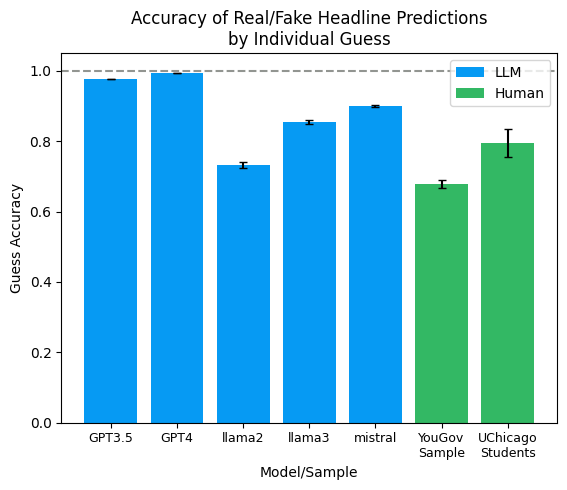

In [15]:
#plot accuracy of guesses with confidence intervals
labels = ['GPT3.5', 'GPT4', 'llama2', 'llama3', 'mistral', 'YouGov\nSample', 'UChicago\nStudents']
plt.bar(labels[:5], metrics.guess_accuracy[:5], yerr=errs[:5], capsize=3, color='xkcd:azure', label='LLM')
plt.bar(labels[5:], metrics.guess_accuracy[5:], yerr=errs[5:], capsize=3, color='xkcd:cool green', label='Human')
plt.xticks(size=9)
plt.legend(loc='upper right')
plt.title('Accuracy of Real/Fake Headline Predictions\nby Individual Guess')
plt.xlabel('Model/Sample')
plt.ylabel('Guess Accuracy')
plt.hlines(y=1,xmin=-.75,xmax=6.75, colors='xkcd:grey', linestyles='dashed')
plt.xlim(-0.75, 6.75)
plt.show()

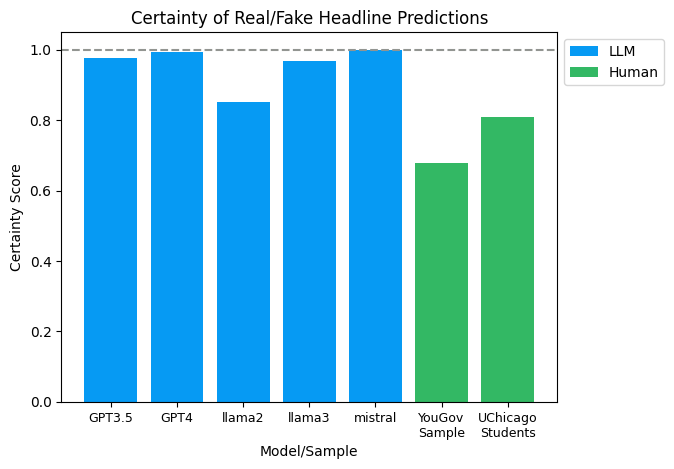

In [16]:
#plot average certainty
plt.bar(labels[:5], metrics.certainty_score[:5], color='xkcd:azure', label='LLM')
plt.bar(labels[5:], metrics.certainty_score[5:], color='xkcd:cool green', label='Human')
plt.xticks(size=9)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Certainty of Real/Fake Headline Predictions')
plt.xlabel('Model/Sample')
plt.ylabel('Certainty Score')
plt.hlines(y=1,xmin=-.75,xmax=6.75, colors='xkcd:grey', linestyles='dashed')
plt.xlim(-0.75, 6.75)
plt.show()

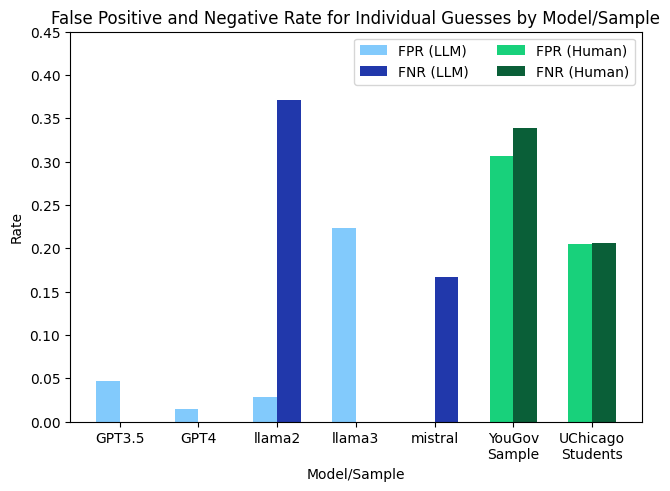

In [17]:
#plot false positives and false negatives
x1 = np.arange(5)
x2 = np.arange(5,7)
fig, ax = plt.subplots(layout='constrained')
ax.bar(x1-.15, metrics.guess_FPR[:5], 0.3, color='xkcd:sky', label='FPR (LLM)')
ax.bar(x1+0.15, metrics.guess_FNR[:5], 0.3, color='xkcd:sapphire',  label='FNR (LLM)')
ax.bar(x2-.15, metrics.guess_FPR[5:], 0.3, color='xkcd:seaweed', label='FPR (Human)')
ax.bar(x2+0.15, metrics.guess_FNR[5:], 0.3, color='xkcd:spruce',  label='FNR (Human)')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rate')
ax.set_xlabel('Model/Sample')
ax.set_title("False Positive and Negative Rate for Individual Guesses by Model/Sample")
ax.set_xticks(np.arange(7), labels)
ax.legend(ncols=2)
ax.set_ylim(0,.45)
plt.show()

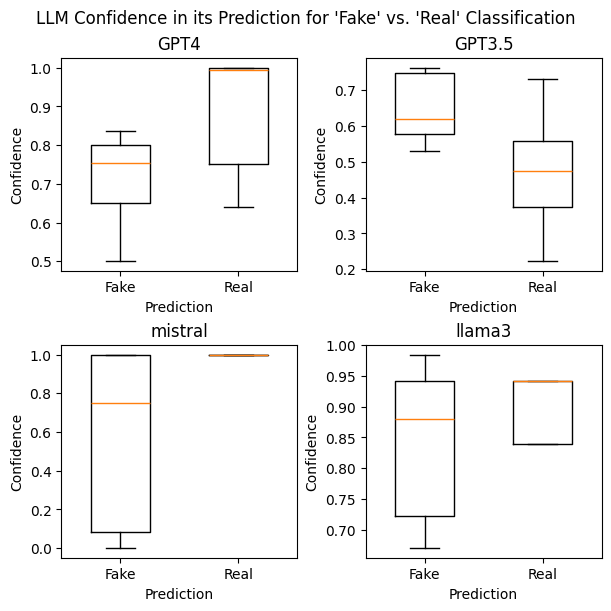

In [18]:
#analysis of the chaining confidence
#boxplots showing confidence by llm separated by original prediction
fig, ax = plt.subplots(2, 2, figsize=(6,6), constrained_layout=True)
ax[0, 0].boxplot([SAMPLES['gpt-4-turbo'].loc[10:, 'gpt-4-turbo_chain_c'], SAMPLES['gpt-4-turbo'].loc[:10, 'gpt-4-turbo_chain_c']], widths=[0.5, 0.5])
ax[0, 1].boxplot([SAMPLES['gpt-3.5-turbo'].loc[10:, 'gpt-3.5-turbo_chain_c'], SAMPLES['gpt-3.5-turbo'].loc[:10, 'gpt-3.5-turbo_chain_c']], widths=[0.5, 0.5])
ax[1, 0].boxplot([SAMPLES['mistral'].loc[SAMPLES['mistral'].mistral_p == 0]['mistral_chain_c'], SAMPLES['mistral'].loc[SAMPLES['mistral'].mistral_p]['mistral_chain_c']], widths=[0.5, 0.5])
ax[1, 1].boxplot([SAMPLES['llama3'].loc[SAMPLES['llama3'].llama3_p == 0]['llama3_chain_c'], SAMPLES['llama3'].loc[SAMPLES['llama3'].llama3_p]['llama3_chain_c']], widths=[0.5, 0.5])
for i, llm in enumerate(['GPT4', 'GPT3.5', 'mistral', 'llama3']):
    ax[i//2, i%2].set_xlabel('Prediction')
    ax[i//2, i%2].set_xticks([1,2], labels=['Fake', 'Real'])
    ax[i//2, i%2].set_ylabel('Confidence')
    ax[i//2, i%2].set_title(llm)
fig.suptitle("LLM Confidence in its Prediction for 'Fake' vs. 'Real' Classification")
plt.show()

# Everything below this point was not used in the project report or presentation, just for EDA and additional analysis.

In [19]:
#explore some of the data by headline (not used in report)
guess_accuracy_by_hl = {}
for hl in range(len(full_data)):
    real = full_data.loc[hl, 'Real']
    guess_accs = []
    for i in range(len(SAMPLES)):
        p = full_data.iloc[hl, 2 + 2*i]
        c = full_data.iloc[hl, 3 + 2*i]
        guess_accs.append(c if p == real else 1 - c)
    guess_accuracy_by_hl[full_data.loc[hl, 'Headline']] = guess_accs
ga_hl = pd.DataFrame(guess_accuracy_by_hl, index = SAMPLES.keys())

In [20]:
#choose some interesting headlines to plot (went back and added the fifth based on the scatterplot below)
total_guess_acc = pd.Series([np.mean(ga_hl[col]) for col in ga_hl.columns])
hls = ga_hl.columns.tolist()
human_hard = sorted(hls, key=lambda x:np.mean(ga_hl.loc[:, x].iloc[5:]))
llm_hard = sorted(hls, key=lambda x:np.mean(ga_hl.loc[:, x].iloc[:5]))
hls = llm_hard[:2] + human_hard[:2] + [ga_hl.columns[7]]
hl_labels = [' '.join(hl.split()[:3]) + '\n' + ' '.join(hl.split()[3:7]) + '\n' + ' '.join(hl.split()[7:]) for hl in hls]
hl_labels = hl_labels[:4] + [' '.join(hls[4].split()[:4]) + '\n' + ' '.join(hls[4].split()[4:8]) + '\n' + ' '.join(hls[4].split()[8:])]

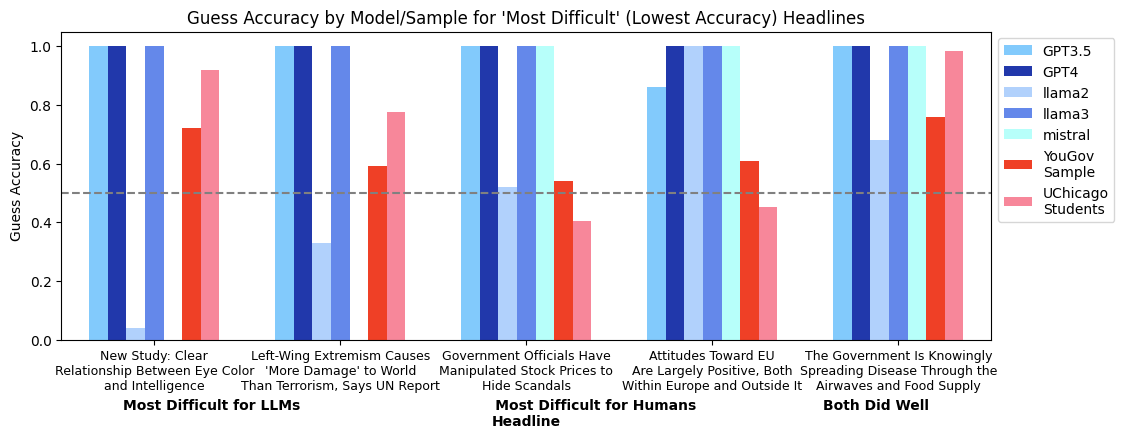

In [21]:
x = np.arange(-2,3)
colors = ['xkcd:sky', 'xkcd:sapphire', 'xkcd:powder blue', 'xkcd:soft blue', 'xkcd:pale cyan', 'xkcd:tomato', 'xkcd:rose pink'] 
fig, ax = plt.subplots(figsize=(12,4))
for i, key in enumerate(SAMPLES.keys()):
    ax.bar(x+0.1*i, ga_hl.loc[key, hls], 0.1, color=colors[i], label=labels[i])
ax.set_xticks(x+0.3, hl_labels, size=9)
ax.hlines(0.5, -2.2, 2.8, linestyle='dashed', color='gray')
ax.set_xlim(-2.2, 2.8)
ax.set_title("Guess Accuracy by Model/Sample for 'Most Difficult' (Lowest Accuracy) Headlines")
ax.set_xlabel('Most Difficult for LLMs                                        Most Difficult for Humans                          Both Did Well\nHeadline', weight='bold')
ax.set_ylabel('Guess Accuracy')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [22]:
#VERY EXPLORATORY LOOK AT HOW THE PERFORMANCES COMPARE
#SHOULD NOT BROADLY GENERALIZE LLMS BY AVERAGING THEIR RESULTS IN THE FINAL REPORT
llm_hl = np.array([np.mean(ga_hl[col][:5]) for col in ga_hl.columns])
hum_hl = np.array([np.mean(ga_hl[col][5:]) for col in ga_hl.columns])

In [23]:
ga_hl = pd.concat([ga_hl, pd.DataFrame({'llm_avg': llm_hl, 'human_avg': hum_hl}, index=ga_hl.columns).T])

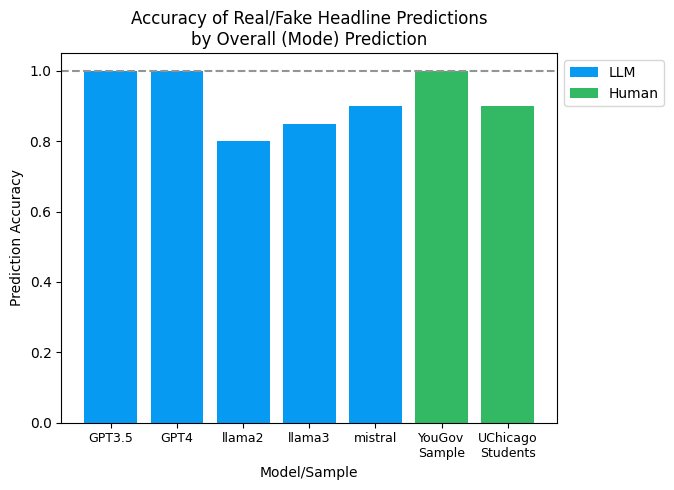

In [24]:
#plot accuracy of predictions
labels = ['GPT3.5', 'GPT4', 'llama2', 'llama3', 'mistral', 'YouGov\nSample', 'UChicago\nStudents']
plt.hlines(y=1,xmin=-.75,xmax=6.75, colors='xkcd:grey', linestyles='dashed')
plt.bar(labels[:5], metrics.headline_accuracy[:5], color='xkcd:azure', label='LLM')
plt.bar(labels[5:], metrics.headline_accuracy[5:], color='xkcd:cool green', label='Human')
plt.xticks(size=9)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Accuracy of Real/Fake Headline Predictions\nby Overall (Mode) Prediction')
plt.xlabel('Model/Sample')
plt.ylabel('Prediction Accuracy')
plt.xlim(-0.75, 6.75)
plt.show()

In [25]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [26]:
#check out a regression
#low r-squared (~1% of variation in LLM accuracy explained by ability of humans to correctly classify a headline)
#not significant slope in t test
X = add_constant(hum_hl)
model = OLS(llm_hl, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.1676
Date:                Fri, 17 May 2024   Prob (F-statistic):              0.687
Time:                        14:02:35   Log-Likelihood:                 16.238
No. Observations:                  20   AIC:                            -28.48
Df Residuals:                      18   BIC:                            -26.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9577      0.164      5.825      0.000       0.612       1.303
x1            -0.0904      0.221     -0.409      0.687      -0.554       0.373
==============================================================================
Omnibus:                        6.946   Durbin-Watson:                   2.582
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                4.762
Skew:                          -1.159   Prob(JB):                       0.0924
Kurtosis:                       3.586   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

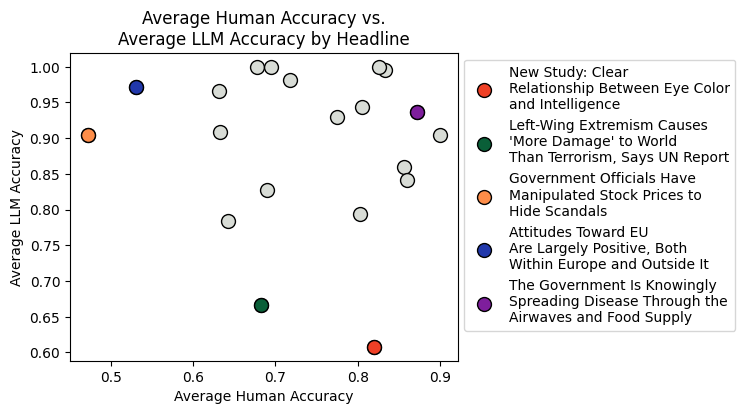

In [28]:
#see how they look, especially the interesting ones, for ourselves, not for report, because averaging LLM results is not good
scatter_colors = ['xkcd:tomato', 'xkcd:spruce', 'xkcd:orangeish', 'xkcd:sapphire', 'xkcd:purple']
plt.figure(figsize=(5,4))
plt.scatter(ga_hl.loc['human_avg'], ga_hl.loc['llm_avg'], color='xkcd:light gray', edgecolors='k', s=100)
for i, hl in enumerate(hls):
    plt.scatter(ga_hl.loc['human_avg', hl], ga_hl.loc['llm_avg', hl], color=scatter_colors[i], edgecolors='k', label=hl_labels[i], s=100)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Average Human Accuracy')
plt.ylabel('Average LLM Accuracy')
plt.title('Average Human Accuracy vs.\nAverage LLM Accuracy by Headline')
plt.show()

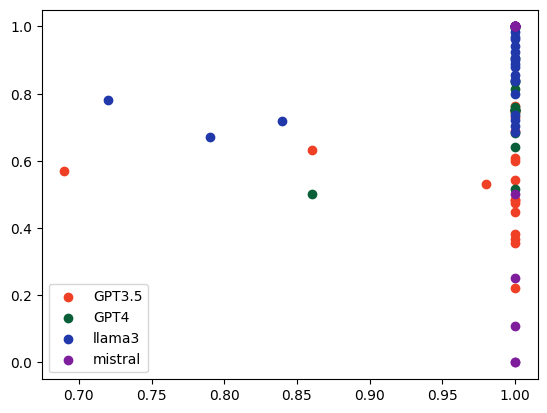

In [29]:
#scatterplot of certainty vs confidence by model (not helpful because of lack of variation in the certainty levels)
for i, item in enumerate(SAMPLES.items()):
    if i in [0, 1, 3, 4]:
        llm, df = item
        wrong = df.loc[df.Real != df[llm + '_p']]
        plt.scatter(df[llm + '_c'], df[llm + '_chain_c'], color=scatter_colors[i], label=labels[i])
plt.legend()
plt.show()